In [1]:
import torch
import torch.nn as nn
# from torchdiffeq import odeint_adjoint as odeint # We'll use this later

# --- 1. The Control Head MLP ---
# Predicts explicit parameters (bounding box, number of points) from the latent vector z.
class ControlHead(nn.Module):
    """
    An MLP that maps a latent vector z to structural parameters for a 2D slice.
    """
    def __init__(self, latent_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            # Output: 4 for bbox (min_x, max_x, min_y, max_y) + 1 for N
            nn.Linear(hidden_dim, 5)
        )
        # Use Softplus to ensure the predicted number of points is always positive.
        self.softplus = nn.Softplus()

    def forward(self, z: torch.Tensor) -> dict:
        """
        Args:
            z (torch.Tensor): Latent vector, shape (B, latent_dim).
        
        Returns:
            dict: A dictionary containing the predicted bounding box and number of points.
        """
        params = self.net(z)
        
        # Bbox logits are returned directly. They can be scaled/activated later.
        bbox = params[..., :4]
        
        # Predict N, ensuring it's a positive value. We add a minimum
        # value to prevent the model from predicting zero points.
        pred_N_logits = params[..., 4]
        pred_N = self.softplus(pred_N_logits).round().long() + 1
        
        return {
            "bbox": bbox,       # Shape: (B, 4)
            "pred_N": pred_N,   # Shape: (B,)
        }

# --- 2. The Generative Core CNF (Skeleton) ---
# This is where the Continuous Normalizing Flow will live.
class GenerativeCore(nn.Module):
    """
    A placeholder for the CNF that generates a point cloud in a normalized space,
    conditioned on the latent vector z.
    """
    def __init__(self, latent_dim: int, hidden_dim: int = 256):
        super().__init__()
        # This network represents the core dynamics of the ODE, f(x, t; z).
        # In the final version, this will be a more sophisticated network,
        # possibly a series of concatenated feed-forward layers.
        self.dynamics_net = nn.Sequential(
            nn.Linear(2 + latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2) # Output: velocity (dx/dt, dy/dt)
        )

    def forward(self, z: torch.Tensor, num_points: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            z (torch.Tensor): Latent vector, shape (B, latent_dim).
            num_points (int): The number of points to generate for each shape in the batch.
        
        Returns:
            tuple:
                - torch.Tensor: Generated points in normalized space, shape (B, N, 2).
                - torch.Tensor: The log-likelihood of the generation, shape (B,).
        """
        # --- This is a placeholder implementation ---
        # The real implementation will use torchdiffeq.
        
        # 1. Sample from a base distribution (e.g., N(0,I)).
        batch_size = z.shape[0]
        base_dist_samples = torch.randn(batch_size, num_points, 2, device=z.device)

        # 2. In the final version, you would integrate the dynamics_net from t=0 to t=1
        #    using `odeint`. `odeint` would also compute the log-likelihood via the
        #    Hutchinson's trace estimator trick.
        
        # Placeholder for generated points:
        # We'll simulate the flow by passing the noise and latent vector through the dynamics net.
        # This is NOT a flow, just a stand-in to ensure the architecture connects.
        z_expanded = z.unsqueeze(1).expand(-1, num_points, -1)
        flow_input = torch.cat([base_dist_samples, z_expanded], dim=-1)
        generated_points = torch.tanh(self.dynamics_net(flow_input)) # tanh to keep in [-1, 1]
        
        # Placeholder for the exact log-likelihood from the CNF.
        log_likelihood = torch.zeros(batch_size, device=z.device)

        return generated_points, log_likelihood

# --- 3. The Main Hybrid Decoder ---
# This class orchestrates the ControlHead and the GenerativeCore.
class HybridDecoder(nn.Module):
    """
    The main decoder module for the 2D Slice VAE.
    """
    def __init__(self, latent_dim: int, control_hidden_dim: int = 128, cnf_hidden_dim: int = 256):
        super().__init__()
        self.control_head = ControlHead(latent_dim, control_hidden_dim)
        self.generative_core = GenerativeCore(latent_dim, cnf_hidden_dim)

    def denormalize(self, points: torch.Tensor, bbox: torch.Tensor) -> torch.Tensor:
        """
        Rescales points from the normalized space [-1, 1] to the predicted bounding box.
        
        Args:
            points (torch.Tensor): Points in normalized space, shape (B, N, 2).
            bbox (torch.Tensor): Predicted bounding boxes, shape (B, 4).
        
        Returns:
            torch.Tensor: Points in the original coordinate space.
        """
        min_x, max_x, min_y, max_y = bbox.chunk(4, dim=-1)
        
        center_x = (max_x + min_x) / 2
        center_y = (max_y + min_y) / 2
        scale_x = (max_x - min_x) / 2
        scale_y = (max_y - min_y) / 2

        points_x = points[..., 0] * scale_x.unsqueeze(-1) + center_x.unsqueeze(-1)
        points_y = points[..., 1] * scale_y.unsqueeze(-1) + center_y.unsqueeze(-1)
        
        return torch.stack([points_x, points_y], dim=-1)

    def forward(self, z: torch.Tensor, target_N: int = None) -> dict:
        """
        The main forward pass for decoding a latent vector into a point cloud.
        
        Args:
            z (torch.Tensor): The latent vector, shape (B, latent_dim).
            target_N (int, optional): The ground-truth number of points for teacher forcing
                                      during training. Defaults to None.
        
        Returns:
            dict: A dictionary containing the final point cloud and other relevant tensors.
        """
        # 1. Predict structural parameters from the latent vector.
        control_params = self.control_head(z)
        bbox = control_params["bbox"]
        
        # During training, we can use the ground-truth N (teacher forcing).
        # During inference, we must use the predicted N.
        # For this skeleton, we assume a single value for the batch.
        num_points_to_gen = target_N if target_N is not None else control_params["pred_N"][0].item()

        # 2. Generate points in normalized space using the CNF core.
        normalized_points, log_likelihood = self.generative_core(z, num_points_to_gen)
        
        # 3. De-normalize the points to fit the predicted bounding box.
        denormalized_points = self.denormalize(normalized_points, bbox)

        return {
            "points": denormalized_points,      # The final generated point cloud
            "log_likelihood": log_likelihood,    # For the reconstruction loss
            "bbox": bbox,                        # The predicted bounding box
            "pred_N": control_params["pred_N"]   # The predicted number of points
        }



In [4]:
import torch
import numpy as np
import os
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm.auto import tqdm

class SlicesDataset(Dataset):
    """
    A PyTorch Dataset that loads slices from a LIMITED number of raw .npy files.
    This is memory-efficient and points to the correct raw data source.
    """
    def __init__(self, npy_dir, limit_files=None):
        self.slices = []
        
        file_list = sorted([f for f in os.listdir(npy_dir) if f.endswith('.npy')])
        if limit_files is not None:
            print(f"Limiting dataset to the first {limit_files} files.")
            file_list = file_list[:limit_files]
        
        print(f"Loading data from {len(file_list)} files...")
        for file_name in tqdm(file_list):
            file_path = os.path.join(npy_dir, file_name)
            try:
                # Load the list of slice arrays from the .npy file
                all_slice_arrays = np.load(file_path, allow_pickle=True)
                for point_array in all_slice_arrays:
                    if point_array.shape[0] > 0:
                        self.slices.append(Data(x=torch.from_numpy(point_array).float()))
            except Exception as e:
                print(f"Skipping corrupted file {file_name}: {e}")

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        return self.slices[idx]

# --- Setup the DataLoader with a small, manageable subset ---
# CORRECTED: Pointing to the raw slices directory
DATA_DIR = "../../outputs/slices/" 
NUM_FILES_TO_TRAIN_ON = 10 # Start with just 10 cars

try:
    poc_dataset = SlicesDataset(npy_dir=DATA_DIR, limit_files=NUM_FILES_TO_TRAIN_ON)
    print(f"\nSuccessfully created a small dataset with a total of {len(poc_dataset)} slices.")

    # We'll use a batch size of 32 slices for training
    poc_dataloader = DataLoader(poc_dataset, batch_size=32, shuffle=True)

    # --- Test the new DataLoader ---
    first_poc_batch = next(iter(poc_dataloader))

    print("\n--- Correctly Formatted PyG Batch from SMALL .npy SUBSET ---")
    print(first_poc_batch)
    print(f"\nTotal number of slices in this batch: {first_poc_batch.num_graphs}")
    print(f"Total number of points in all slices in this batch: {first_poc_batch.num_nodes}")

except (IOError, FileNotFoundError) as e:
    print(e)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Limiting dataset to the first 10 files.
Loading data from 10 files...


100%|██████████| 10/10 [00:00<00:00, 351.13it/s]


Successfully created a small dataset with a total of 800 slices.

--- Correctly Formatted PyG Batch from SMALL .npy SUBSET ---
DataBatch(x=[46217, 2], batch=[46217], ptr=[33])

Total number of slices in this batch: 32
Total number of points in all slices in this batch: 46217


In [3]:
# --- Setup for our single test file ---
DATA_DIR = "../../outputs/slices/"
TEST_FILE_NAME = "DrivAer_F_D_WM_WW_0001_axis-x.npy"
test_file_path = os.path.join(DATA_DIR, TEST_FILE_NAME)

try:
    # THE FIX: Removed the keyword 'file_path='
    single_file_dataset = SingleFileNpyDataset(test_file_path)
    
    # Batch size > number of slices to get all slices from our one car at once
    single_file_dataloader = DataLoader(single_file_dataset, batch_size=100) 

    # --- Run the Test ---
    single_car_batch = next(iter(single_file_dataloader))

    print("\n--- Correctly Formatted PyG Batch from SINGLE .npy FILE ---")
    print(single_car_batch)
    print(f"\nTotal number of slices in this batch: {single_car_batch.num_graphs}")
    print(f"Total number of points in all slices in this batch: {single_car_batch.num_nodes}")

except (IOError, FileNotFoundError) as e:
    print(e)

NameError: name 'SingleFileNpyDataset' is not defined

In [48]:
import torch
import torch.nn as nn
from torch_geometric.nn import EdgeConv, knn_graph, global_max_pool
from torch_geometric.data import Batch

class DGCNN_VAE_Encoder_PyG(nn.Module):
    """
    The final, optimized VAE Encoder for 2D slices using PyTorch Geometric.
    """
    def __init__(self, latent_dim=128, k=20):
        super().__init__()
        self.k = k
        self.latent_dim = latent_dim

        # Layer 1: Takes 2D points -> 64-dim features
        self.conv1 = EdgeConv(
            nn=nn.Sequential(
                nn.Linear(2 * 2, 64),
                nn.LeakyReLU(0.2),
            ),
            aggr="max"
        )

        # Layer 2: Takes 64-dim features -> 128-dim features
        self.conv2 = EdgeConv(
            nn=nn.Sequential(
                nn.Linear(2 * 64, 128),
                nn.LeakyReLU(0.2),
            ),
            aggr="max"
        )
        
        # Global feature aggregator
        self.fc = nn.Sequential(
            nn.Linear(64 + 128, 1024),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(1024, 256)
        )
        
        # VAE output layers for mu and log_var
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)

    def forward(self, data: Batch) -> (torch.Tensor, torch.Tensor):
        # data.x contains all points from all slices, shape: [total_points, 2]
        # data.batch contains the slice index for each point, shape: [total_points]

        # --- Layer 1 ---
        edge_index1 = knn_graph(data.x, k=self.k, batch=data.batch)
        h1 = self.conv1(data.x, edge_index1)

        # --- Layer 2 (Dynamic Graph) ---
        # Build the new graph on the FEATURES from Layer 1
        edge_index2 = knn_graph(h1, k=self.k, batch=data.batch)
        h2 = self.conv2(h1, edge_index2)

        # --- Aggregate Features ---
        h_combined = torch.cat([h1, h2], dim=1)
        global_feature = global_max_pool(h_combined, data.batch)
        
        # --- Final Layers ---
        global_feature = self.fc(global_feature)
        mu = self.fc_mu(global_feature)
        log_var = self.fc_log_var(global_feature)
        
        return mu, log_var

print("Optimized PyG-based Encoder architecture defined.")

Optimized PyG-based Encoder architecture defined.


In [49]:
# --- 1. Set up the model and device ---
LATENT_DIM = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of our encoder and move it to the correct device
encoder = DGCNN_VAE_Encoder_PyG(latent_dim=LATENT_DIM, k=20).to(DEVICE)
encoder.eval() # Set the model to evaluation mode for this test

# --- 2. Move the data to the correct device ---
# The 'single_car_batch' is from Notebook Cell 2
batch_on_device = single_car_batch.to(DEVICE)

# --- 3. Pass the batch through the encoder ---
with torch.no_grad():
    mu, log_var = encoder(batch_on_device)

# --- 4. Check the results ---
print(f"Input was a batch with {batch_on_device.num_graphs} slices.")
print("\n--- Output Shapes ---")
print(f"  - mu vector shape: {mu.shape}")
print(f"  - log_var vector shape: {log_var.shape}")

# --- 5. Sanity check the values ---
print("\n--- Example Output Values (mu, first 5 slices) ---")
print(mu[:5])

Input was a batch with 80 slices.

--- Output Shapes ---
  - mu vector shape: torch.Size([80, 128])
  - log_var vector shape: torch.Size([80, 128])

--- Example Output Values (mu, first 5 slices) ---
tensor([[ 3.7364e-02,  2.9910e-02,  5.0200e-02, -3.1608e-02, -7.5958e-02,
          3.4142e-02,  2.7590e-02, -6.1911e-02, -1.8707e-02, -8.9737e-02,
         -2.2632e-03, -7.4745e-02,  2.5395e-02, -2.4939e-02, -2.5143e-02,
          1.4177e-02,  6.1716e-02,  3.0645e-03, -2.8931e-02,  3.4949e-02,
         -1.1050e-02, -5.4430e-02,  3.1064e-03,  3.5054e-02, -7.9312e-02,
         -4.1653e-02, -6.8330e-02, -1.0872e-02,  4.7025e-02,  3.4532e-02,
          3.6045e-02,  6.1124e-02,  5.3892e-02,  5.0488e-02,  6.3993e-02,
         -3.8044e-02,  8.8524e-02,  3.7512e-02,  3.8550e-02, -9.3991e-03,
          6.4512e-04,  6.6446e-02, -6.8560e-02,  9.4123e-03, -5.0288e-02,
         -3.0981e-03, -1.8068e-02,  4.5526e-02, -1.1319e-03,  1.1359e-02,
          1.4685e-02, -5.1980e-02, -4.0908e-02, -3.6909e-02,

In [50]:
import torch
import torch.nn as nn

class ControlHead(nn.Module):
    """
    A simple MLP that predicts the 'scaffolding' for a 2D slice from a latent vector.
    - A 4-value bounding box (min_x, max_x, min_y, max_y)
    - A 1-value estimated point count (N)
    """
    def __init__(self, latent_dim=128, hidden_dim=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            # We output 5 continuous values
            nn.Linear(hidden_dim, 5) 
        )
        # Use softplus activation for the point count to ensure it's always positive
        self.softplus = nn.Softplus()

    def forward(self, z):
        # z has shape (batch_size, latent_dim)
        params = self.mlp(z)
        
        # The first 4 values are for the bounding box
        bbox = params[:, :4]
        
        # The 5th value is for the point count N. We apply softplus to ensure N > 0.
        # We add 1 to avoid predicting N=0, which can cause issues.
        n_points = self.softplus(params[:, 4].unsqueeze(1)) + 1
        
        return bbox, n_points

print("ControlHead module defined.")

ControlHead module defined.


In [51]:
# --- 1. Set up the model and device ---
# This must match the latent_dim of our encoder
LATENT_DIM = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

control_head = ControlHead(latent_dim=LATENT_DIM).to(DEVICE)
control_head.eval()

# --- 2. Use the 'mu' tensor from the previous cell as our test input z ---
# 'mu' is already on the correct device if the previous cell ran successfully
# mu has shape [80, 128]
test_z = mu 

# --- 3. Pass the batch through the control head ---
with torch.no_grad():
    predicted_bbox, predicted_n_points = control_head(test_z)

# --- 4. Check the results ---
print(f"Input z shape: {test_z.shape}")
print("\n--- Output Shapes ---")
print(f"  - Predicted bbox shape: {predicted_bbox.shape}")
print(f"  - Predicted N points shape: {predicted_n_points.shape}")

# --- 5. Sanity check the values ---
print("\n--- Example Output Values (first 5 slices) ---")
print("BBox [min_x, max_x, min_y, max_y]:")
print(predicted_bbox[:5])
print("\nN Points (estimated):")
print(predicted_n_points[:5])

Input z shape: torch.Size([80, 128])

--- Output Shapes ---
  - Predicted bbox shape: torch.Size([80, 4])
  - Predicted N points shape: torch.Size([80, 1])

--- Example Output Values (first 5 slices) ---
BBox [min_x, max_x, min_y, max_y]:
tensor([[-0.0524, -0.0039, -0.0465, -0.0084],
        [-0.0527, -0.0036, -0.0468, -0.0085],
        [-0.0526, -0.0031, -0.0470, -0.0087],
        [-0.0526, -0.0026, -0.0473, -0.0089],
        [-0.0526, -0.0022, -0.0473, -0.0090]])

N Points (estimated):
tensor([[1.6926],
        [1.6928],
        [1.6927],
        [1.6926],
        [1.6926]])


In [52]:
import torch
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint

class ODEFunc(nn.Module):
    """The neural network that defines the 'wind map'. Now accepts z in forward pass."""
    def __init__(self, latent_dim=128, hidden_dim=256):
        super().__init__()
        # The network now takes a concatenated (point_coords, z) as input directly
        self.net = nn.Sequential(
            nn.Linear(2 + latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2),
        )

    def forward(self, t, y_and_z):
        # y_and_z is a tuple: (point_positions, latent_vector)
        y, z = y_and_z
        
        # Expand z to match the number of points
        z_expanded = z.unsqueeze(1).expand(-1, y.shape[1], -1)
        
        # Concatenate each point's position with the shared latent vector
        nn_input = torch.cat([y, z_expanded], dim=2)
        
        # The output of the network is the 'wind' for the points (dy/dt)
        # The 'wind' for z is zero, as it's a constant throughout the integration
        zero_for_z = torch.zeros_like(z)

        return (self.net(nn_input), zero_for_z)

class GenerativeCore(nn.Module):
    """The 'Sculptor' module that generates points using a Continuous Normalizing Flow."""
    def __init__(self, latent_dim=128):
        super().__init__()
        self.ode_func = ODEFunc(latent_dim=latent_dim)
        self.integration_times = torch.tensor([0.0, 1.0])

    def generate(self, z, num_points):
        """The FORWARD 'blob-to-slice' pass (for generation)."""
        blob = torch.randn(z.shape[0], num_points, 2).to(z.device)
        
        # We now pass a tuple (initial_points, z) to the solver.
        # z will be passed through the ODE solver but its gradient will be zero.
        initial_state = (blob, z)
        self.integration_times = self.integration_times.to(z.device)
        
        solution_y, _ = odeint(self.ode_func, initial_state, self.integration_times, method='dopri5')
        
        return solution_y[1] # Return the point positions at t=1

    def get_log_likelihood(self, slice_points, z):
        """The REVERSE 'slice-to-blob' pass (for training)."""
        initial_state = (slice_points, z)
        self.integration_times = self.integration_times.to(z.device)
        
        reverse_solution_y, _ = odeint(self.ode_func, initial_state, self.integration_times.flip(0), method='dopri5')
        
        blob_points = reverse_solution_y[1]

        log_p_blob = torch.distributions.Normal(0, 1).log_prob(blob_points).sum(dim=[1, 2])
        
        return log_p_blob

print("GenerativeCore module defined (Corrected).")

GenerativeCore module defined (Corrected).


In [53]:
# --- 1. Set up the models and device ---
LATENT_DIM = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generative_core = GenerativeCore(latent_dim=LATENT_DIM).to(DEVICE)
generative_core.eval()

# --- 2. Create some dummy data ---
batch_size = 4
num_points_to_generate = 500
test_z = torch.randn(batch_size, LATENT_DIM).to(DEVICE)

# --- 3. Test the FORWARD pass (generation) ---
with torch.no_grad():
    generated_points = generative_core.generate(test_z, num_points_to_generate)
print("--- Forward Pass Test (Generation) ---")
print(f"Input z shape: {test_z.shape}")
print(f"Number of points to generate: {num_points_to_generate}")
print(f"Output points shape: {generated_points.shape}") # Should be [4, 500, 2]

# --- 4. Test the REVERSE pass (log likelihood) ---
with torch.no_grad():
    log_likelihood = generative_core.get_log_likelihood(generated_points, test_z)
print("\n--- Reverse Pass Test (Log Likelihood) ---")
print(f"Input points shape: {generated_points.shape}")
print(f"Input z shape: {test_z.shape}")
print(f"Output log_likelihood shape: {log_likelihood.shape}") # Should be [4]
print(f"Example log_likelihood values: {log_likelihood.cpu().numpy()}")

--- Forward Pass Test (Generation) ---
Input z shape: torch.Size([4, 128])
Number of points to generate: 500
Output points shape: torch.Size([4, 500, 2])

--- Reverse Pass Test (Log Likelihood) ---
Input points shape: torch.Size([4, 500, 2])
Input z shape: torch.Size([4, 128])
Output log_likelihood shape: torch.Size([4])
Example log_likelihood values: [-1381.3058 -1443.263  -1412.0374 -1405.3706]


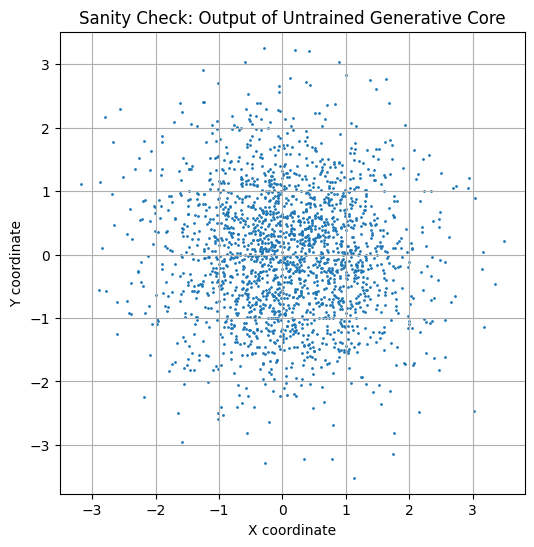

In [54]:
import matplotlib.pyplot as plt

# --- 1. Set up the model and device (as before) ---
LATENT_DIM = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generative_core = GenerativeCore(latent_dim=LATENT_DIM).to(DEVICE)
generative_core.eval()

# --- 2. Create a single random latent vector ---
# We'll generate one slice for this visualization
test_z = torch.randn(1, LATENT_DIM).to(DEVICE)
num_points = 2000 # Let's generate a decent number of points

# --- 3. Generate the 2D point cloud ---
with torch.no_grad():
    generated_points = generative_core.generate(test_z, num_points)

# --- 4. Plot the result ---
# Move points to the CPU and convert to a numpy array for plotting
points_np = generated_points.squeeze(0).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(points_np[:, 0], points_np[:, 1], s=1) # s=1 makes the points small
plt.title("Sanity Check: Output of Untrained Generative Core")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.axis('equal')
plt.grid(True)
plt.show()

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Batch

# We assume the modules from the previous cells are defined:
# - DGCNN_VAE_Encoder_PyG
# - ControlHead
# - GenerativeCore

class SliceVAE(nn.Module):
    """
    The complete Variational Autoencoder for 2D slices.
    Combines the Encoder and the Hybrid Decoder (ControlHead + GenerativeCore).
    """
    def __init__(self, latent_dim=128, k=20):
        super().__init__()
        self.encoder = DGCNN_VAE_Encoder_PyG(latent_dim=latent_dim, k=k)
        self.control_head = ControlHead(latent_dim=latent_dim)
        self.generative_core = GenerativeCore(latent_dim=latent_dim)
        
    def reparameterize(self, mu, log_var):
        """Standard VAE reparameterization trick."""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, data: Batch):
        # Encode the batch of slices to get latent distributions
        mu, log_var = self.encoder(data)
        
        # Sample from the latent distributions to get z
        z = self.reparameterize(mu, log_var)
        
        # The decoder uses z to predict the scaffolding and generate the shape
        predicted_bbox, predicted_n = self.control_head(z)
        
        # For this forward pass, we return everything needed to calculate the loss
        return mu, log_var, z, predicted_bbox, predicted_n

    def loss_function(self, data: Batch, mu, log_var, z, predicted_bbox, predicted_n):
        # --- 1. Reconstruction Loss (from Generative Core) ---
        # The decoder needs to reconstruct each slice in the batch.
        # We process each slice's points individually.
        
        # First, we need to "unbatch" the data from the PyG Batch object
        slice_points_list = [data.x[data.batch == i] for i in range(data.num_graphs)]
        
        # The Generative Core needs the points to have a batch dimension for its ODE solver
        # We'll process one slice at a time for simplicity in the loss calculation
        recon_loss = 0
        for i in range(data.num_graphs):
            slice_points = slice_points_list[i].unsqueeze(0) # Add batch dim: [1, N, 2]
            slice_z = z[i].unsqueeze(0) # Add batch dim: [1, latent_dim]
            
            # get_log_likelihood returns a single value for this one slice
            log_likelihood = self.generative_core.get_log_likelihood(slice_points, slice_z)
            recon_loss -= log_likelihood # We want to MAXIMIZE likelihood, so we MINIMIZE negative likelihood
        
        recon_loss = recon_loss / data.num_graphs # Average over the batch

        # --- 2. KL Divergence Loss ---
        # This keeps the latent space smooth and organized
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        kl_loss = kl_loss / data.num_graphs # Average over the batch

        # --- 3. Control Head Loss ---
        # Teach the control head to predict the correct bbox and point count
        
        # Get ground truth values
        actual_n = torch.tensor([s.shape[0] for s in slice_points_list], dtype=torch.float32).to(z.device).unsqueeze(1)
        
        # For bbox, find the min/max of the actual points for each slice
        actual_bboxes = []
        for s in slice_points_list:
            min_coords, _ = torch.min(s, dim=0)
            max_coords, _ = torch.max(s, dim=0)
            actual_bboxes.append(torch.cat([min_coords, max_coords]))
        actual_bboxes = torch.stack(actual_bboxes, dim=0).to(z.device)
        
        bbox_loss = F.l1_loss(predicted_bbox, actual_bboxes)
        n_loss = F.l1_loss(predicted_n, actual_n)
        control_loss = bbox_loss + n_loss
        
        return recon_loss, kl_loss, control_loss

print("Complete SliceVAE model defined.")

Complete SliceVAE model defined.


In [57]:
import torch.optim as optim
from tqdm.auto import tqdm

# --- 1. Setup Model, Optimizer, and Data ---
LATENT_DIM = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the 'single_file_dataloader' we created and tested in the previous steps
# It loads all slices from our one test car.
dataloader = poc_dataloader

model = SliceVAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
kl_weight = 0.1 # A weight to balance the KL loss against the other losses
control_weight = 1.0 # A weight for the bbox and N prediction loss

# --- 2. The Training Loop ---
NUM_EPOCHS = 500 # For a single car, we can train for more epochs to see clear progress
print(f"Starting training for {NUM_EPOCHS} epochs on device: {DEVICE}")

for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
    model.train()
    
    total_recon_loss = 0
    total_kl_loss = 0
    total_control_loss = 0
    
    # Since our dataloader contains all slices for one car, one batch is one epoch
    for batch in dataloader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        
        # Forward pass
        mu, log_var, z, predicted_bbox, predicted_n = model(batch)
        
        # Calculate loss components
        recon_loss, kl_loss, control_loss = model.loss_function(
            batch, mu, log_var, z, predicted_bbox, predicted_n
        )
        
        # Combine losses with weights
        total_loss = recon_loss + (kl_weight * kl_loss) + (control_weight * control_loss)
        
        # Backward pass and optimize
        total_loss.backward()
        optimizer.step()
        
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_control_loss += control_loss.item()
        
    # Print progress every 25 epochs
    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
              f"Total Loss: {total_loss.item():.4f} | "
              f"Recon Loss: {total_recon_loss:.4f} | "
              f"KL Loss: {total_kl_loss:.4f} | "
              f"Control Loss: {total_control_loss:.4f}")

print("\nTraining complete.")

Starting training for 500 epochs on device: cpu


Epochs:   0%|          | 0/500 [02:59<?, ?it/s]


KeyboardInterrupt: 

### Test and Validation

In [ ]:
import matplotlib.pyplot as plt

# --- 1. Set model to evaluation mode ---
model.eval()

# --- 2. Get the same batch of data we trained on ---
batch = next(iter(dataloader)).to(DEVICE)
original_slices = [data.x for data in batch.to_data_list()]

# --- 3. Run the full autoencoder pipeline ---
with torch.no_grad():
    # Get the latent vector 'mu' (the center of the fuzzy cloud) for reconstruction
    mu, log_var = model.encoder(batch)
    
    # Decode mu to get the scaffolding and the normalized points
    predicted_bbox, predicted_n = model.control_head(mu)
    
    # We use the predicted N to generate a variable number of points for each slice
    reconstructed_slices_normalized = []
    for i in range(len(mu)):
        num_points = int(predicted_n[i].round().item())
        z_slice = mu[i].unsqueeze(0)
        # Generate points in the [-1, 1] box
        points = model.generative_core.generate(z_slice, num_points)
        reconstructed_slices_normalized.append(points.squeeze(0))

# --- 4. De-normalize the reconstructions ---
reconstructed_slices_final = []
for i in range(len(reconstructed_slices_normalized)):
    points = reconstructed_slices_normalized[i]
    bbox = predicted_bbox[i]
    min_coords = bbox[:2]
    max_coords = bbox[2:4]
    
    # Stretch the points from [-1, 1] to the predicted bbox
    scale = (max_coords - min_coords) / 2.0
    center = (max_coords + min_coords) / 2.0
    final_points = points * scale + center
    reconstructed_slices_final.append(final_points)

# --- 5. Visualize the results ---
num_to_show = 5
fig, axes = plt.subplots(num_to_show, 2, figsize=(8, 12))
fig.suptitle("Model Reconstruction vs. Original", fontsize=16)
axes[0, 0].set_title("Original Slice")
axes[0, 1].set_title("Reconstructed Slice")

for i in range(num_to_show):
    original = original_slices[i*10].cpu().numpy() # Show every 10th slice
    reconstructed = reconstructed_slices_final[i*10].cpu().numpy()
    
    # Plot original
    axes[i, 0].scatter(original[:, 0], original[:, 1], s=1, c='blue')
    axes[i, 0].set_aspect('equal', adjustable='box')
    axes[i, 0].set_ylabel(f"Slice {i*10}")
    
    # Plot reconstructed
    axes[i, 1].scatter(reconstructed[:, 0], reconstructed[:, 1], s=1, c='red')
    axes[i, 1].set_aspect('equal', adjustable='box')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()